In [ ]:
# ======================================================
# Step 1: Setup (Mount Drive, Install packages)
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision timm scikit-learn tqdm

# ======================================================
# Step 2: Unzip your dataset into /content/
# ======================================================
!rm -rf /content/DATA
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"

# Check dataset structure
!ls /content/DATA
!ls /content/DATA/train

Mounted at /content/drive
test  train  val
 acne   Eczema	 Psoriasis  'Tinea Ringworm'


In [ ]:
!pip install timm torch torchvision scikit-learn tqdm

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch 1/40
Train Loss: 0.8877, Train Acc: 0.5954
Val Loss: 0.7933, Val Acc: 0.6329
Epoch 2/40
Train Loss: 0.6808, Train Acc: 0.7107
Val Loss: 0.7352, Val Acc: 0.6836
Epoch 3/40
Train Loss: 0.6112, Train Acc: 0.7372
Val Loss: 0.6348, Val Acc: 0.7272
Epoch 4/40
Train Loss: 0.5412, Train Acc: 0.7805
Val Loss: 0.5894, Val Acc: 0.7505
Epoch 5/40
Train Loss: 0.4855, Train Acc: 0.8037
Val Loss: 0.5781, Val Acc: 0.7535
Epoch 6/40
Train Loss: 0.4327, Train Acc: 0.8306
Val Loss: 0.5659, Val Acc: 0.7647
Epoch 7/40
Train Loss: 0.4027, Train Acc: 0.8465
Val Loss: 0.5718, Val Acc: 0.7698
Epoch 8/40
Train Loss: 0.3520, Train Acc: 0.8682
Val Loss: 0.5459, Val Acc: 0.7819
Epoch 9/40
Train Loss: 0.3392, Train Acc: 0.8695
Val Loss: 0.5406, Val Acc: 0.7972
Epoch 10/40
Train Loss: 0.3004, Train Acc: 0.8884
Val Loss: 0.5275, Val Acc: 0.7880
Epoch 11/40
Train Loss: 0.2863, Train Acc: 0.8940
Val Loss: 0.5617, Val Acc: 0.7901
Epoch 12/40
Train Loss: 0.2614, Train Acc: 0.9003
Val Loss: 0.5759, Val Acc: 0.7890
E

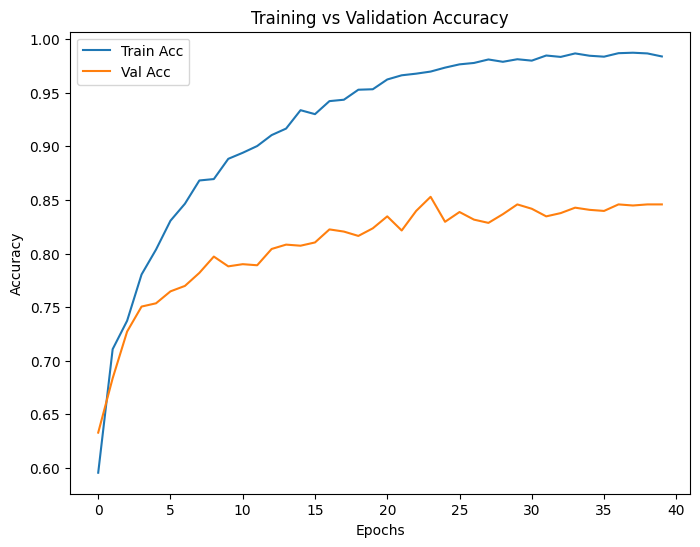

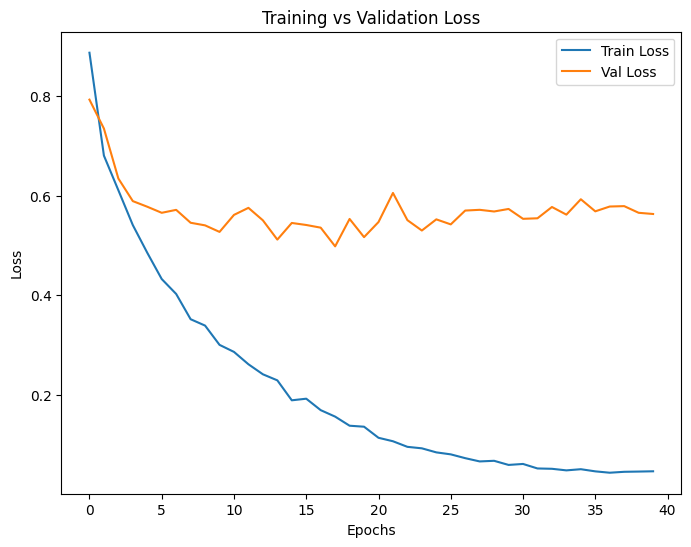


Classification Report:
                precision    recall  f1-score   support

        Eczema       0.77      0.77      0.77       253
     Psoriasis       0.81      0.80      0.81       309
Tinea Ringworm       0.81      0.83      0.82       256
          acne       0.99      1.00      1.00       173

      accuracy                           0.83       991
     macro avg       0.85      0.85      0.85       991
  weighted avg       0.83      0.83      0.83       991



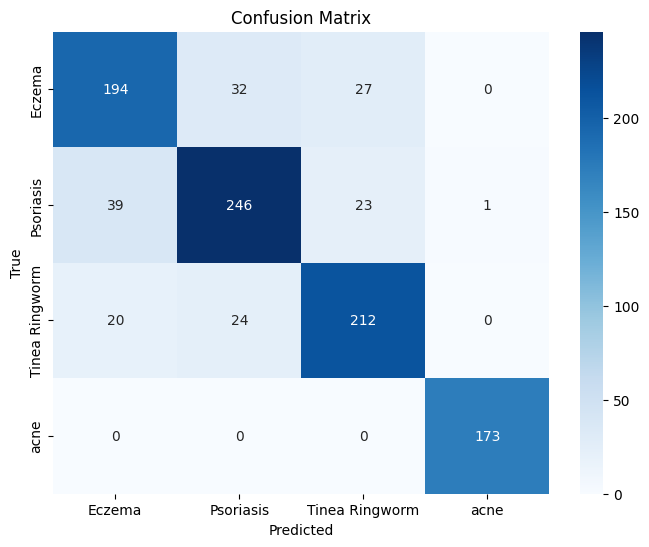

Test Accuracy: 83.25%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm

# ======================================================
# Config
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/DATA"   # change path accordingly
batch_size = 16
num_epochs = 40
lr = 1e-4

# ======================================================
# Data Augmentation
# ======================================================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ======================================================
# Datasets & Loaders
# ======================================================
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

class_names = train_dataset.classes

# Balanced Sampler
class_counts = np.bincount([y for _, y in train_dataset.samples])
class_weights = 1. / class_counts
weights = [class_weights[y] for _, y in train_dataset.samples]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ======================================================
# Model: DenseNet121
# ======================================================
model = timm.create_model("densenet121", pretrained=True, num_classes=len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# ======================================================
# Training Function
# ======================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        train_loss /= total
        train_acc = train_correct.double() / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_correct += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct.double() / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, history

# ======================================================
# Train
# ======================================================
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# ======================================================
# Plots: Accuracy & Loss
# ======================================================
plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Training vs Validation Accuracy")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Training vs Validation Loss")
plt.show()

# ======================================================
# Evaluation on Test Set
# ======================================================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# Test Accuracy
test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Test Accuracy: {test_acc*100:.2f}%")


In [ ]:
import torch
import pickle
import h5py

save_path = "/content/drive/MyDrive/LYProject"

# ✅ Save as .pkl
with open(save_path + "densenet121_model.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)

# ✅ Save as .h5
with h5py.File(save_path + "densenet121_model.h5", "w") as f:
    for key, val in model.state_dict().items():
        f.create_dataset(key, data=val.cpu().numpy())

print("✅ Model saved in Google Drive at:", save_path)



✅ Model saved in Google Drive at: /content/drive/MyDrive/LYProject
